In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.distributions as dist
import torch.optim as optim

import beanmachine.ppl as bm
from beanmachine.ppl.model.statistical_model import StatisticalModel
from beanmachine.ppl.model.utils import Mode
from beanmachine.ppl.world import World
import beanmachine.ppl.experimental.inference_compilation.ic_infer as ic_infer

sns.set_style('darkgrid')

import importlib
importlib.reload(ic_infer)

<module 'beanmachine.ppl.experimental.inference_compilation.ic_infer' from '/home/jovyan/work/beanmachine/src/beanmachine/ppl/experimental/inference_compilation/ic_infer.py'>

In [2]:
print(
    torch.cuda.is_available(),
    torch.cuda.current_device(),
)
#device = torch.device("cuda")
device = torch.device("cpu")

True 0


In [36]:
np.sqrt(2**2 + .1**2)

2.0024984394500787

In [3]:
std = 2.0
sigma = 0.1

@bm.random_variable
def p():
    return dist.Normal(
        torch.tensor(0.).to(device=device), 
        torch.tensor(std).to(device=device)
    )

@bm.random_variable
def x():
    return dist.Normal(
        p(),
        torch.tensor(sigma).to(device=device)
    )

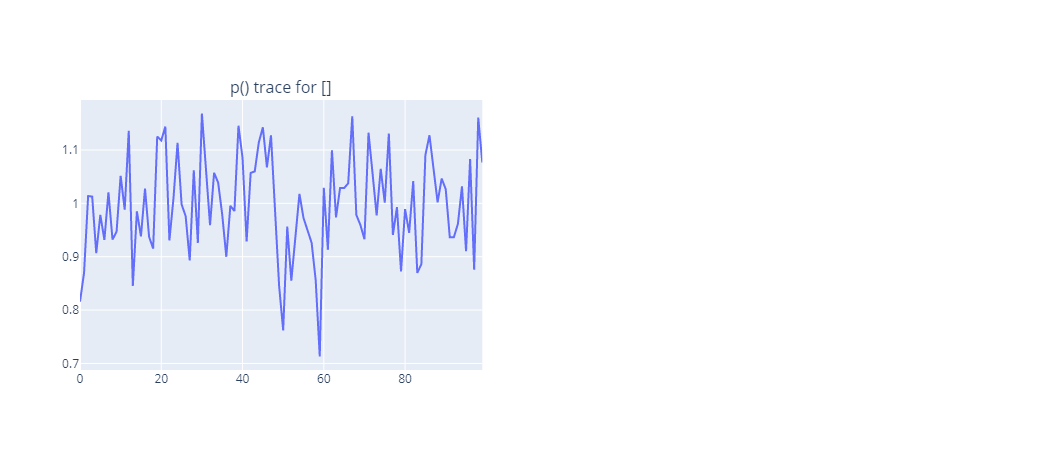

avg       std      2.5%       50%     97.5%      n_eff
p()[]  0.995742  0.092218  0.829755  0.992365  1.153538  58.521175

In [4]:
mh = bm.CompositionalInference()
samples = mh.infer(
    [p()], 
    {x(): torch.tensor(1.).to(device=device),}, 
    num_samples=100,
    num_chains=1,
)
diagnostics = bm.Diagnostics(samples)
diagnostics.trace([p()])[0].show()
diagnostics.summary()

Loss: tensor([0.4144], grad_fn=<AddBackward0>))


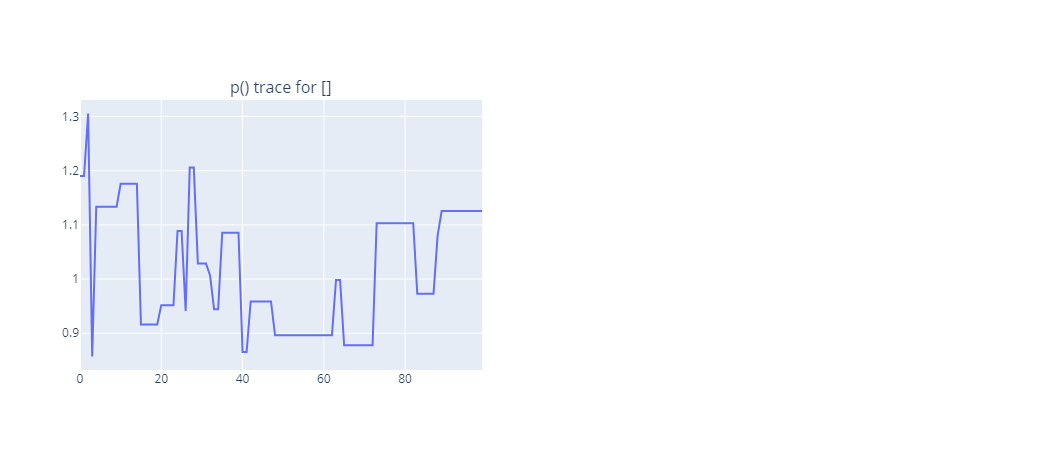

avg       std      2.5%       50%     97.5%     n_eff
p()[]  1.01846  0.111148  0.871178  0.998268  1.198343  9.282444

In [27]:
import importlib; importlib.reload(ic_infer)
ic = ic_infer.ICInference()
ic.compile(
    [x()],
    num_worlds=1e3,
    batch_size=1,
    optimizer_func=lambda x: optim.Adam(x, lr=1e-3),
)
samples = ic.infer(
    [p()], 
    {x(): torch.tensor(1.).to(device=device),}, 
    num_samples=100,
    num_chains=1,
)
diagnostics = bm.Diagnostics(samples)
diagnostics.trace([p()])[0].show()
diagnostics.summary()

When the observations are close to the prior distributions (i.e. where IC's training data has good representation), we see higher n_eff than NMC.

In [28]:
def ic_proposal_dist(ic, obs):
    mh = bm.CompositionalInference()
    mh.queries_ = [p()]
    mh.observations_ = {x(): torch.tensor(obs, dtype=torch.float32)}
    mh.initialize_world()
    world = mh.world_
    StatisticalModel.set_mode(Mode.INITIALIZE)
    proposal_dist = ic.find_best_single_site_proposer(p()).get_proposal_distribution(
        p(),
        world.get_node_in_world_raise_error(p()),
        world,
        {}
    )[0].proposal_distribution
    
    return proposal_dist

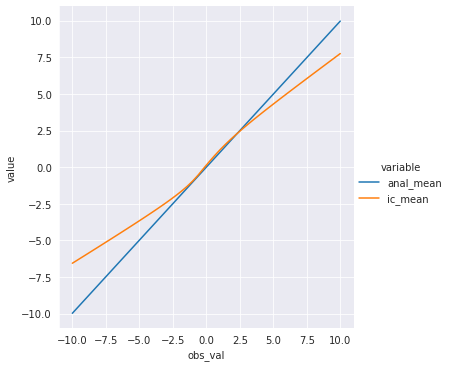

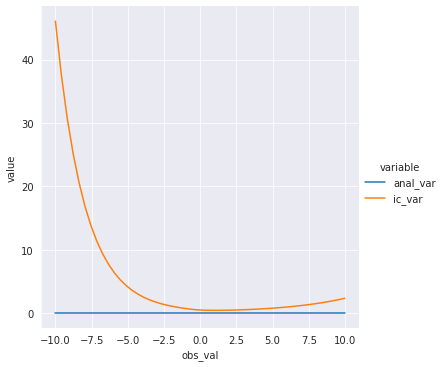

In [29]:
data = []
for obs in np.linspace(-10,10,num=50):
    proposal_dist = ic_proposal_dist(ic, obs)
    ic_params = (
        proposal_dist.component_distribution.base_dist.loc.item(),
        proposal_dist.component_distribution.base_dist.scale.item()
    )
    data.append({
        'obs_val': obs,
        'anal_mean': (obs / sigma**2) * (1.0 / (1.0 / std**2 + 1.0 / sigma**2)),
        'ic_mean': ic_params[0],
        'anal_var': (1.0 / (1.0 / std**2 + 1.0 / sigma**2)),
        'ic_var': ic_params[1]**2,
    })
data = pd.DataFrame(data)
melted = data.melt(id_vars=['obs_val'])

for var in ['mean', 'var']:
    sns.relplot(
        data=melted[
            melted['variable'].map(lambda x: x.endswith(var))
        ],
        x='obs_val',
        y='value',
        hue='variable',
        kind='line',
    )

In [30]:
dd = melted[
    melted['variable'].map(lambda x: x.endswith("mean"))
]
dd = dd.rename(columns={
    'obs_val': 'y (Observed value)',
})
dd['variable'] = dd['variable'].replace({
    'anal_mean': 'Closed-form mean',
    'ic_mean': 'Mean of LIC proposer',
})

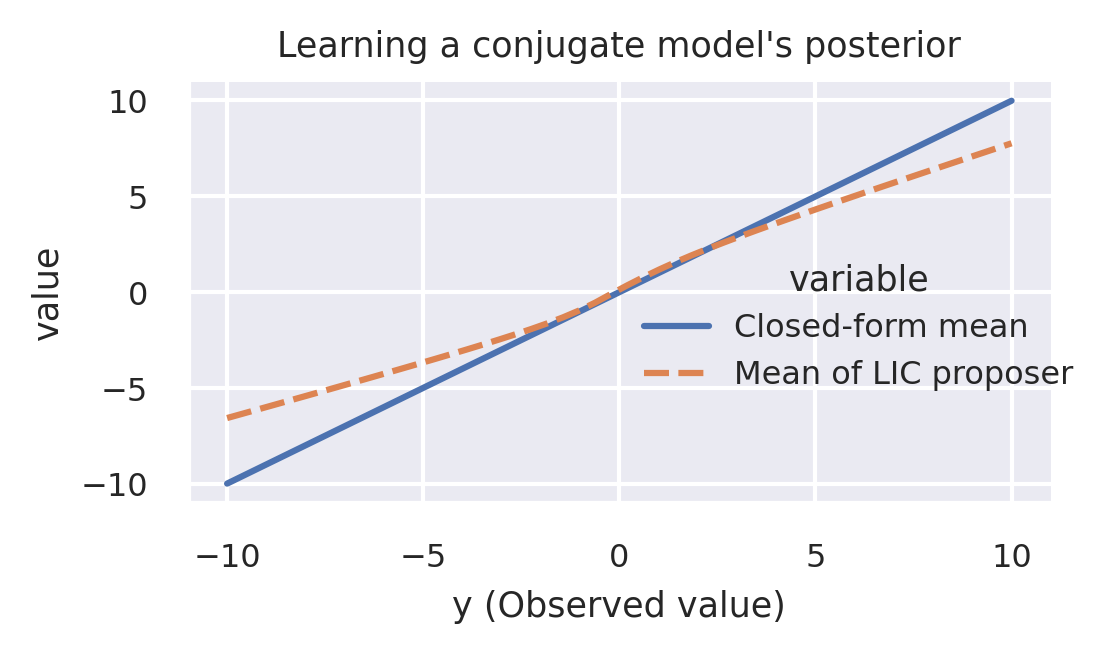

In [33]:
import pickle
#pickle.dump(dd, open("outputs/normalnormal.pkl", "wb"))
dd = pickle.load(open("outputs/normalnormal.pkl", "rb"))
sns.set(font_scale=0.7)
g = sns.relplot(
    data=dd,
    x='y (Observed value)',
    y='value',
    hue='variable',
    kind='line',
    style='variable',
)
g.set(title="Learning a conjugate model's posterior")
g.fig.set_size_inches(8.5*0.4, 2)
g.fig.set_dpi(300)
g.fig.tight_layout()
g.fig.savefig('normal_normal_mean.pdf', dpi=300, bbox_inches='tight')

Hard to tell... What about when we observe values very far away from the prior

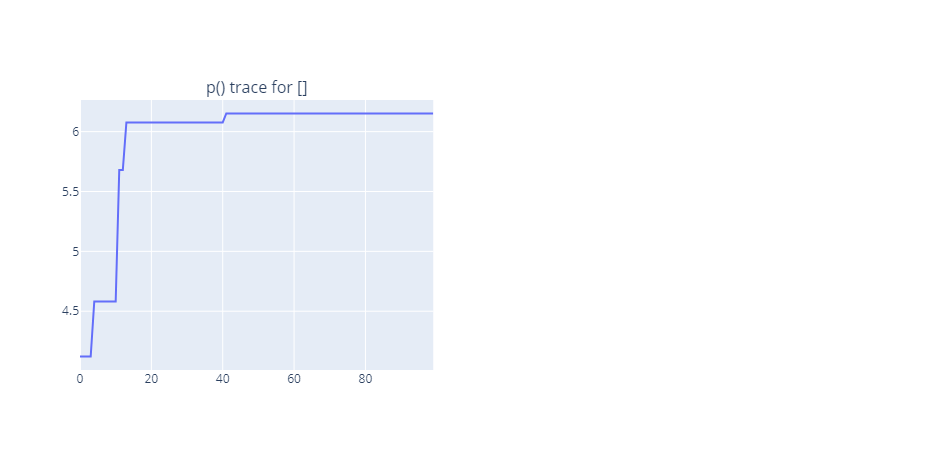

avg       std      2.5%       50%     97.5%     n_eff
p()[]  5.930047  0.545339  4.121772  6.151475  6.151475  7.848065

In [20]:
samples = ic.infer(
    [p()], 
    {x(): torch.tensor(10.).to(device=device),}, 
    num_samples=100,
    num_chains=1,
)
diagnostics = bm.Diagnostics(samples)
diagnostics.trace([p()])[0].show()
diagnostics.summary()

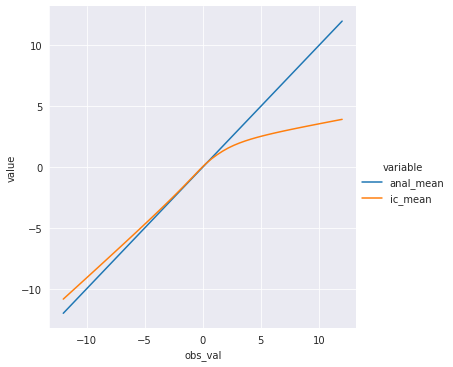

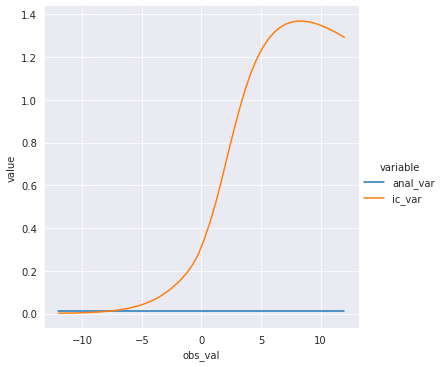

In [21]:
data = []
for obs in np.linspace(-12,12,num=50):
    proposal_dist = ic_proposal_dist(ic, obs)
    ic_params = (
        proposal_dist.component_distribution.base_dist.loc.item(),
        proposal_dist.component_distribution.base_dist.scale.item()
    )
    data.append({
        'obs_val': obs,
        'anal_mean': (obs / sigma**2) * (1.0 / (1.0 / std**2 + 1.0 / sigma**2)),
        'ic_mean': ic_params[0],
        'anal_var': (1.0 / (1.0 / std**2 + 1.0 / sigma**2)),
        'ic_var': ic_params[1]**2,
    })
data = pd.DataFrame(data)
melted = data.melt(id_vars=['obs_val'])

for var in ['mean', 'var']:
    sns.relplot(
        data=melted[
            melted['variable'].map(lambda x: x.endswith(var))
        ],
        x='obs_val',
        y='value',
        hue='variable',
        kind='line',
    )

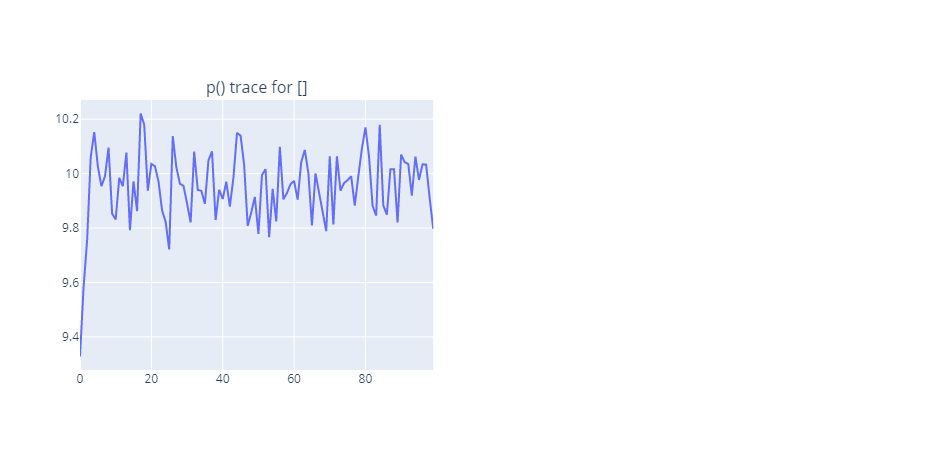

avg       std      2.5%      50%      97.5%      n_eff
p()[]  9.952188  0.131179  9.738131  9.96412  10.174705  70.993698

In [22]:
samples = mh.infer(
    [p()], 
    {x(): torch.tensor(10.).to(device=device),}, 
    num_samples=100,
    num_chains=1,
)
diagnostics = bm.Diagnostics(samples)
diagnostics.trace([p()])[0].show()
diagnostics.summary()

ESS is quite low compared to NMC, presumably due to the very high variance at x=10 because there wasn't much training data from prior sampling there.

Does adaptation help?

Loss: 0.2324554920196533247


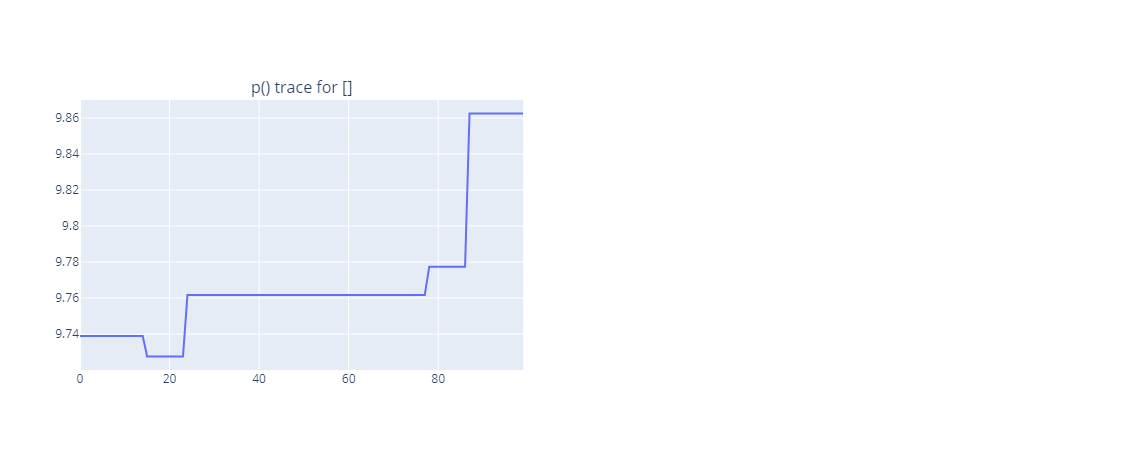

avg       std      2.5%      50%     97.5%    n_eff
p()[]  9.769735  0.038403  9.727559  9.76172  9.862473  5.59129

In [23]:
samples = ic.infer(
    [p()], 
    {x(): torch.tensor(10.).to(device=device),}, 
    num_adaptive_samples=int(1e3),
    num_samples=100,
    num_chains=1,
)
diagnostics = bm.Diagnostics(samples)
diagnostics.trace([p()])[0].show()
diagnostics.summary()

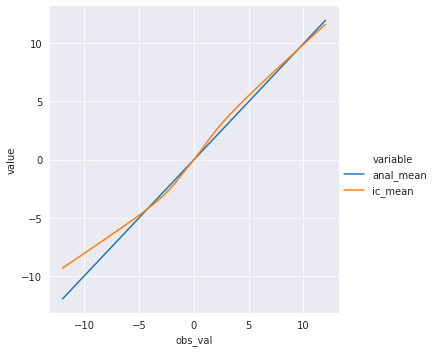

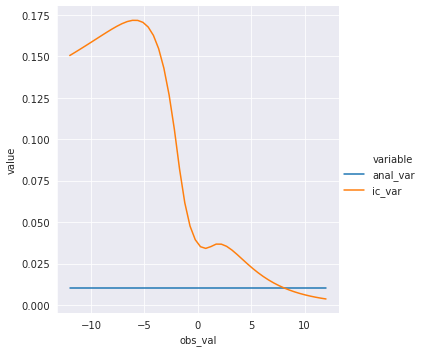

In [58]:
data = []
for obs in np.linspace(-12,12,num=50):
    proposal_dist = ic_proposal_dist(ic, obs)
    ic_params = (
        proposal_dist.component_distribution.base_dist.loc.item(),
        proposal_dist.component_distribution.base_dist.scale.item()
    )
    data.append({
        'obs_val': obs,
        'anal_mean': (obs / sigma**2) * (1.0 / (1.0 / std**2 + 1.0 / sigma**2)),
        'ic_mean': ic_params[0],
        'anal_var': (1.0 / (1.0 / std**2 + 1.0 / sigma**2)),
        'ic_var': ic_params[1]**2,
    })
data = pd.DataFrame(data)
melted = data.melt(id_vars=['obs_val'])

for var in ['mean', 'var']:
    sns.relplot(
        data=melted[
            melted['variable'].map(lambda x: x.endswith(var))
        ],
        x='obs_val',
        y='value',
        hue='variable',
        kind='line',
    )

Yep. ESS is higher and the variance at x=10 is much more reasonable now.

Adding many GMM components

Loss: tensor([-0.6123], grad_fn=<AddBackward0>)


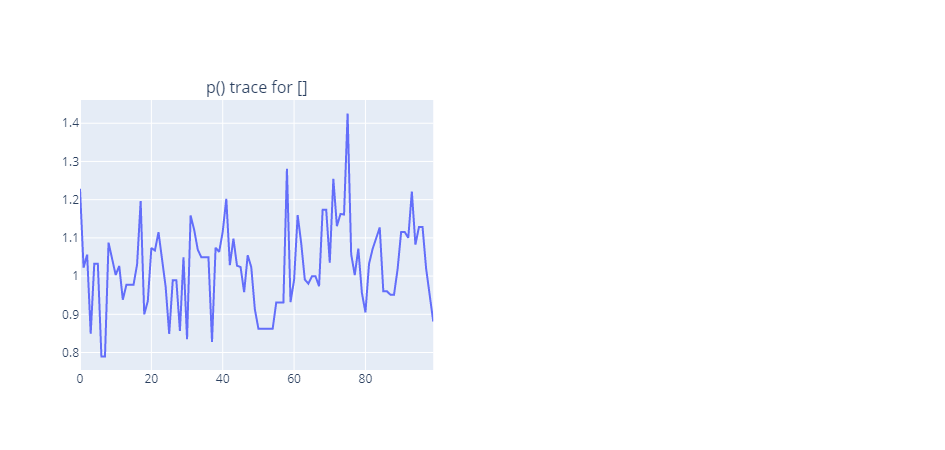

avg       std      2.5%       50%     97.5%      n_eff
p()[]  1.025633  0.112259  0.831083  1.027853  1.242163  39.645409

In [39]:
import importlib; importlib.reload(ic_infer)
ic = ic_infer.ICInference()
ic.compile(
    [x()],
    num_worlds=3e3,
    batch_size=1,
    optimizer_func=lambda x: optim.Adam(x, lr=1e-3),
    gmm_num_components=10,
)
samples = ic.infer(
    [p()], 
    {x(): torch.tensor(1.).to(device=device),}, 
    num_samples=100,
    num_chains=1,
)
diagnostics = bm.Diagnostics(samples)
diagnostics.trace([p()])[0].show()
diagnostics.summary()

## Entropy regularization (broken by mixture proposer)

The posterior mean is well matched by the IC proposer across a range of observed values, but the variance is overestimated. Can we address this with entropy regularization?

In [40]:
ic_entropy = ic_infer.ICInference()
ic_entropy.compile(
    [x()],
    num_worlds=1e4,
    batch_size=1,
    optimizer_func=lambda x: optim.Adam(x, lr=1e-2),
    entropy_regularization_coefficient=0.5,
)
samples = ic_entropy.infer(
    [p()], 
    {x(): torch.tensor(1.).to(device=device),}, 
    num_samples=100,
    num_chains=1,
)
diagnostics = bm.Diagnostics(samples)
diagnostics.trace([p()])[0].show()
diagnostics.summary()

NotImplementedError: 

In [9]:
data = []
for obs in np.linspace(-2,2,num=50):
    proposal_dist = ic_proposal_dist(ic_entropy, obs)
    ic_params = (proposal_dist.loc.item(), proposal_dist.scale.item())
    data.append({
        'obs_val': obs,
        'anal_mean': (obs / sigma**2) * (1.0 / (1.0 / std**2 + 1.0 / sigma**2)),
        'ic_entropy_mean': ic_params[0],
        'anal_var': (1.0 / (1.0 / std**2 + 1.0 / sigma**2)),
        'ic_entropy_var': ic_params[1]**2,
    })
data = pd.DataFrame(data)
melted = data.melt(id_vars=['obs_val'])

for var in ['mean', 'var']:
    sns.relplot(
        data=melted[
            melted['variable'].map(lambda x: x.endswith(var))
        ],
        x='obs_val',
        y='value',
        hue='variable',
        kind='line',
    )

AttributeError: 'MixtureSameFamily' object has no attribute 'loc'

## Overfitting a normal

In [143]:
import torch
import torch.distributions as dist
import torch.nn as nn
import torch.optim as optim
from torch import tensor
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import math
import seaborn as sns
sns.set_style('darkgrid')

class SimpleICNetwork(nn.Module):
    def __init__(self, obs_embed_dim=4, latent_embed_dim=4, proposer_activation=True):
        super().__init__()
        self.obs_embed = nn.Linear(in_features=1, out_features=obs_embed_dim)
        self.latent_embed = nn.Linear(in_features=1, out_features=latent_embed_dim)
        self.proposer_param = nn.Linear(
            in_features=obs_embed_dim + latent_embed_dim,
            out_features=2)
        if proposer_activation:
            self.proposer_param = nn.Sequential(
                self.proposer_param,
                nn.ELU(),
                nn.Linear(
                    in_features=2,
                    out_features=2,
                )
            )
        
    def forward(self, obs, latent):
        obs_vec = self.obs_embed(obs)
        latent_vec = self.latent_embed(latent)
        return self.proposer_param(torch.cat([obs_vec, latent_vec], dim=1))
        #return self.proposer_param(obs_vec)
    
std = 2.0
sigma = 0.1

def data_generator(batch_size, num_obs_per_latent):
    while True:
        p = dist.Normal(tensor(0.0), std).sample(sample_shape=(batch_size,))
        for _ in range(num_obs_per_latent):
            x = dist.Normal(p, sigma).sample()
            yield (p.unsqueeze(1), x.unsqueeze(1))

In [144]:
def run(
    lr=1e-1,
    batch_size=16,
    num_worlds=1e4,
    entropy_coef=0.0,
    num_entropy_reg_worlds=-1,
    obs_embed_dim=4,
    latent_embed_dim=4,
    proposer_activation=True,
    num_obs_per_latent=1,
):
    net = SimpleICNetwork(obs_embed_dim, latent_embed_dim, proposer_activation)
    opt = optim.Adam(net.parameters(), lr=lr)

    
    num_batches = int(math.ceil(num_worlds / batch_size))

    data_gen = data_generator(batch_size, num_obs_per_latent)
    for i in tqdm(range(num_batches), position=0, leave=True):
        opt.zero_grad()
        latent, obs = next(data_gen)
        proposer_params = net(obs, latent)
        loss = 0.0
        for j in range(proposer_params.shape[0]):
            proposer = dist.Normal(
                loc=proposer_params[j,0],
                scale=torch.exp(proposer_params[j,1]),
            )
            loss -= proposer.log_prob(latent[j])
            
#             if (
#                 num_entropy_reg_worlds is None 
#                 or i*batch_size <= num_entropy_reg_worlds
#             ):
#                 loss += entropy_coef * proposer.entropy()

            # penalize mismatch in norm and large var explicitly
#             loss += torch.norm(proposer_params[j,0] - latent[j])
#             loss += torch.norm(proposer_params[j,1])
        loss.backward()
        opt.step()

        print_every = int(num_batches / 20)
        if (print_every == 0) or (i % print_every == 0):
            tqdm.write(f"Obs: {obs}, Latent: {latent}, Params: {proposer_params}, Loss: {loss}", end="")

    data = []
    for obs in np.linspace(-2,2,num=50):
        ic_params = net(tensor([[float(obs)]]), tensor([[0.0]]))[0].detach().numpy()
        data.append({
            'obs_val': obs,
            'anal_mean': (obs / sigma**2) * (1.0 / (1.0 / std**2 + 1.0 / sigma**2)),
            'ic_mean': ic_params[0],
            'anal_var': (1.0 / (1.0 / std**2 + 1.0 / sigma**2)),
            'ic_var': ic_params[1]**2,
        })
    data = pd.DataFrame(data)
    
    melted = data.melt(id_vars=['obs_val'])
    return melted

## Gibbs resampling observations

If we never resample latents, we expect IC to collapse on the single latent values

Obs: tensor([[-1.3389]]), Latent: tensor([[-1.3921]]), Params: tensor([[-2.9039,  0.7634]], grad_fn=<AddmmBackward>), Loss: tensor([1.9306], grad_fn=<RsubBackward1>)ard1>)


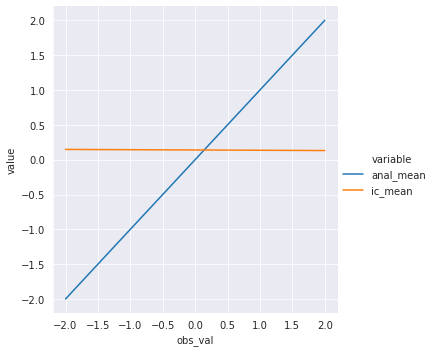

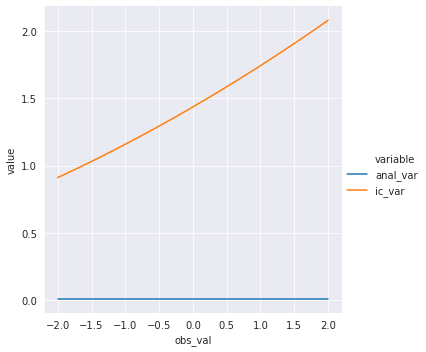

In [145]:
num_worlds = int(1e4)
melted = run(
    lr=1e-2,
    batch_size=1,
    num_worlds=num_worlds,
    entropy_coef=0.0,
    obs_embed_dim=4,
    latent_embed_dim=4,
    proposer_activation=True,
)

for var in ['mean', 'var']:
    sns.relplot(
        data=melted[
            melted['variable'].map(lambda x: x.endswith(var))
        ],
        x='obs_val',
        y='value',
        hue='variable',
        kind='line',
    )

### Reducing Model Parameters

tensor([[ 1.8079],
        [ 1.3392],
        [ 2.4338],
        [-3.8894],
        [ 4.7802],
        [-0.7642],
        [ 0.2793],
        [ 2.5096],
        [ 1.5117],
        [-1.9814],
        [-3.0427],
        [ 1.9204],
        [-0.1743],
        [ 0.0643],
        [ 0.3609],
        [-1.5664]])
Params: tensor([[0.7619, 0.1767],
        [0.7661, 0.1642],
        [0.7571, 0.1912],
        [0.8134, 0.0210],
        [0.7344, 0.2600],
        [0.7850, 0.1071],
        [0.7766, 0.1323],
        [0.7548, 0.1982],
        [0.7648, 0.1682],
        [0.7960, 0.0738],
        [0.8068, 0.0411],
        [0.7614, 0.1785],
        [0.7806, 0.1201],
        [0.7782, 0.1274],
        [0.7763, 0.1332],
Params: tensor([[0.6465, 0.1857],n=<AddmmBackward>), Loss: tensor([49.7115], grad_fn=<SubBackward0>)
        [0.6014, 0.2957],
        [0.5266, 0.4781],
        [0.5766, 0.3561],
        [0.5053, 0.5302],
        [0.5168, 0.5020],
        [0.5171, 0.5014],
        [0.6456, 0.1879],
        [0.423

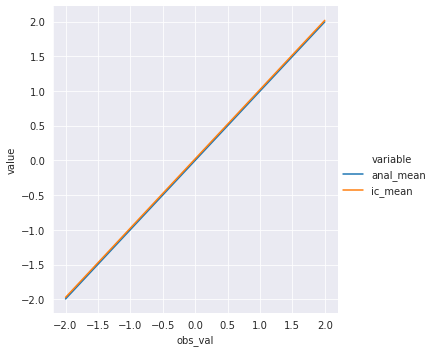

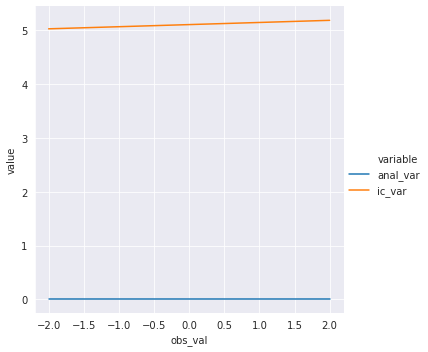

In [32]:
melted = run(
    lr=1e-2,
    batch_size=16,
    num_worlds=1e4,
    entropy_coef=0.0,
    obs_embed_dim=1,
    latent_embed_dim=0,
    proposer_activation=False,
)

for var in ['mean', 'var']:
    sns.relplot(
        data=melted[
            melted['variable'].map(lambda x: x.endswith(var))
        ],
        x='obs_val',
        y='value',
        hue='variable',
        kind='line',
    )

## Entropy REgularization

tensor([[ 3.4810],
        [ 0.8307],
        [ 1.8550],
        [-2.0107],
        [-0.1925],
        [-1.5305],
        [ 0.6006],
        [ 1.3063],
        [-3.6732],
        [-0.4729],
        [ 1.3516],
        [ 1.4551],
        [-1.6208],
        [ 2.2926],
        [-1.3404],
        [ 1.4594]])
Params: tensor([[-9.4554e-01, -2.2369e-01],
        [-6.6556e-01,  4.0479e-02],
        [-7.7184e-01, -5.4079e-02],
        [-4.1730e-01,  5.3888e-02],
        [-5.6820e-01,  8.7921e-02],
        [-4.5452e-01,  7.4251e-02],
        [-6.4104e-01,  6.2564e-02],
        [-7.1393e-01,  4.7667e-04],
        [-3.1234e-01, -2.0391e-02],
        [-5.4209e-01,  9.4458e-02],
        [-7.1886e-01, -4.5940e-03],
        [-7.3231e-01, -2.4535e-02],
        [-4.4761e-01,  7.0418e-02],
        [-8.1707e-01, -9.3935e-02],
        [-4.7052e-01,  7.8901e-02],
Params: tensor([[ 1.4927, -0.3811],, grad_fn=<AddmmBackward>), Loss: tensor([59.2485], grad_fn=<SubBackward0>)
        [ 0.0761,  0.0073],
        

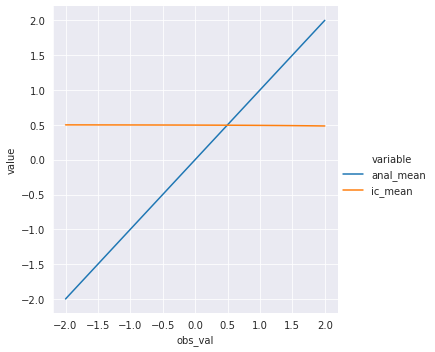

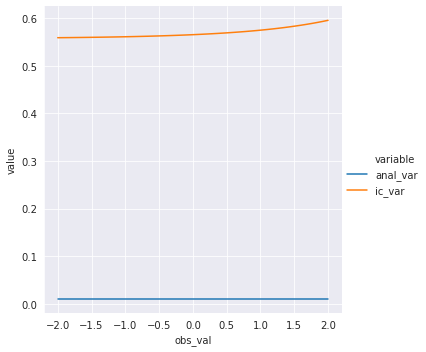

In [33]:
melted = run(
    lr=1e-1,
    batch_size=16,
    num_worlds=1e4,
    entropy_coef=10.0,
    num_entropy_reg_worlds=1e4,
    obs_embed_dim=4,
    latent_embed_dim=4,
    proposer_activation=True,
)

for var in ['mean', 'var']:
    sns.relplot(
        data=melted[
            melted['variable'].map(lambda x: x.endswith(var))
        ],
        x='obs_val',
        y='value',
        hue='variable',
        kind='line',
    )


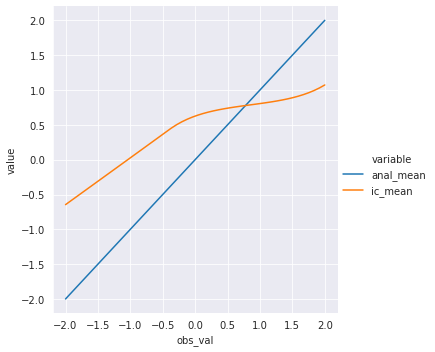

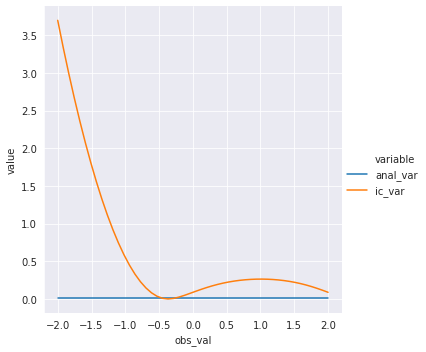

In [8]:
melted = run(
    lr=1e-1,
    batch_size=16,
    num_worlds=1e4,
    entropy_coef=10.0,
    num_entropy_reg_worlds=0.5e4,
    obs_embed_dim=4,
    latent_embed_dim=4,
    proposer_activation=True,
)

for var in ['mean', 'var']:
    sns.relplot(
        data=melted[
            melted['variable'].map(lambda x: x.endswith(var))
        ],
        x='obs_val',
        y='value',
        hue='variable',
        kind='line',
    )